In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''

import argparse

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data import EMNISTLines2

## More challenging EMNISTLines

Now that we've seen the `IAMLines` dataset, we can make our synthetic dataset look more like it by changing the shape of the canvas into which we embed the sentence crops, and by adding data augmentations.

In [2]:
dataset = EMNISTLines2(args=argparse.Namespace())
dataset.prepare_data()
dataset.setup()
print(dataset)

EMNISTLines2 generating data for train...
EMNISTLines2 generating data for val...
EMNISTLines2 generating data for test...
EMNISTLines2 loading data from HDF5...


c:\users\liyz0\.conda\envs\fsdl-text-recognizer-2021\lib\site-packages\torchvision\transforms\transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
c:\users\liyz0\.conda\envs\fsdl-text-recognizer-2021\lib\site-packages\torchvision\transforms\transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


EMNISTLines2 Dataset
Min overlap: 0.2
Max overlap: 0.5
Num classes: 83
Dims: (1, 56, 1024)
Output dims: (89, 1)
Train/val/test sizes: 10000, 2000, 2000
Batch x stats: (torch.Size([128, 1, 56, 1024]), torch.float32, tensor(0.), tensor(0.0159), tensor(0.0932), tensor(0.9961))
Batch y stats: (torch.Size([128, 89]), torch.int64, tensor(1), tensor(66))



In [3]:
def convert_y_label_to_string(y, dataset=dataset):
    # NOTE: we ignore padding tokens
    return ''.join([dataset.mapping[i] for i in y if i != 3])

y_example = dataset.data_train[0][1]
print(y_example, y_example.shape)
convert_y_label_to_string(y_example)

tensor([ 1, 55, 47, 40, 58, 44, 66, 54, 45, 66, 27, 44, 62, 40, 57, 50, 66, 62,
        48, 51, 51,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]) torch.Size([89])


'<S>phase of Newark will<E>'

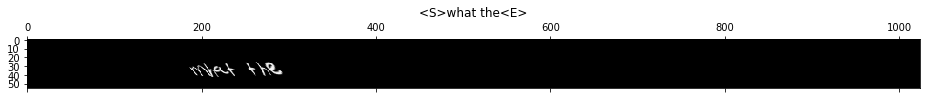

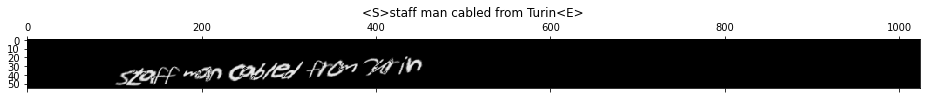

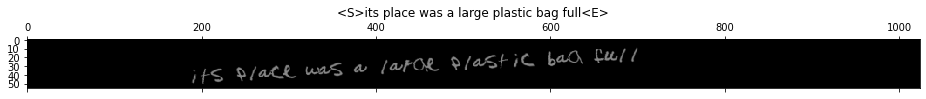

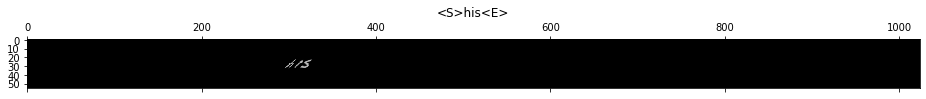

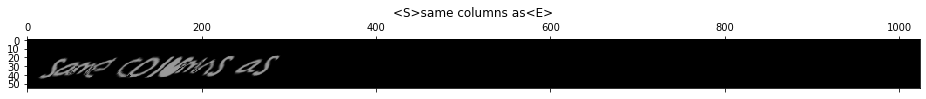

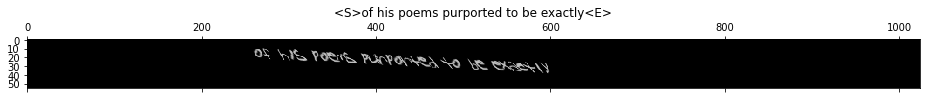

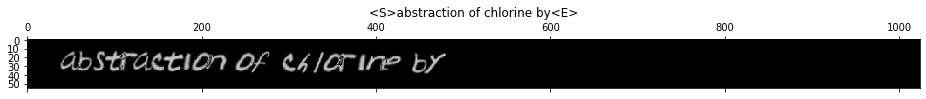

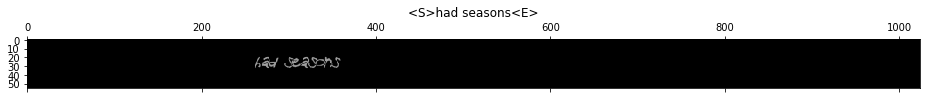

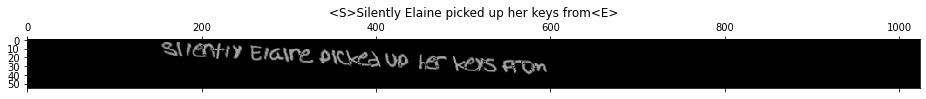

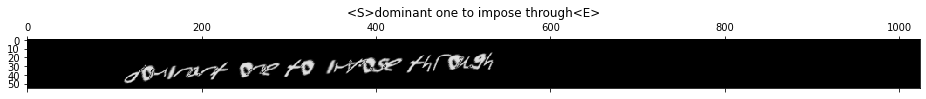

In [4]:
## Train

X, Y = next(iter(dataset.train_dataloader()))
for i in range(10):
    x, y = X[i], Y[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(sentence)

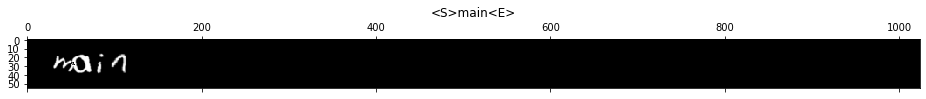

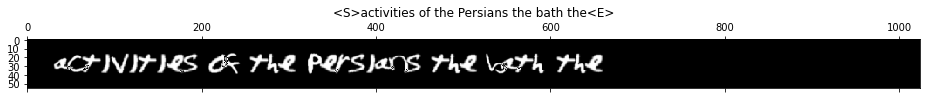

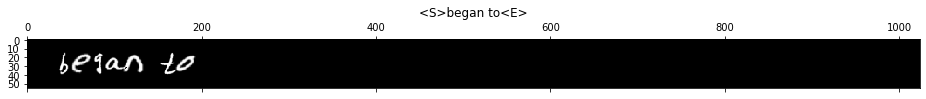

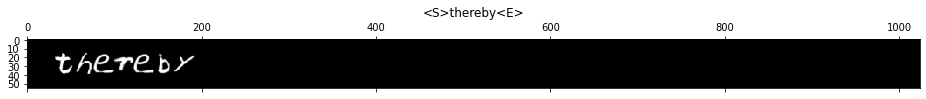

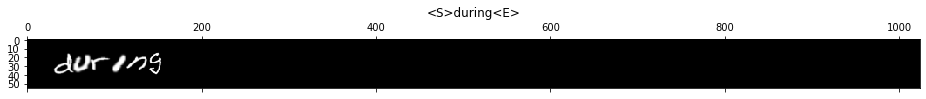

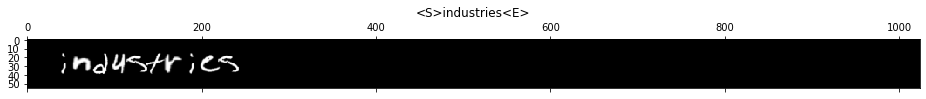

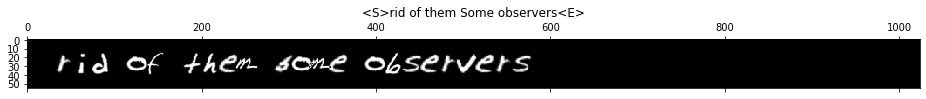

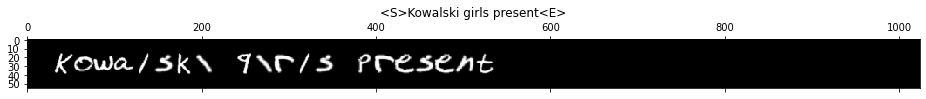

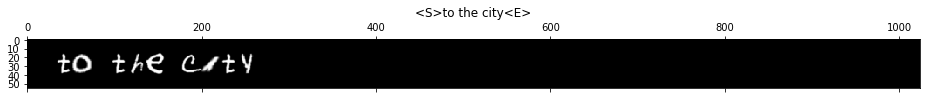

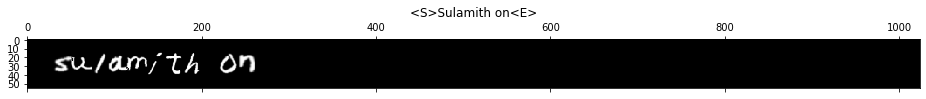

In [5]:
## Test

X, Y = next(iter(dataset.test_dataloader()))
for i in range(10):
    x, y = X[i], Y[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(sentence)

## See predictions of a trained model

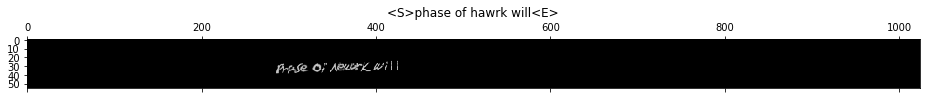

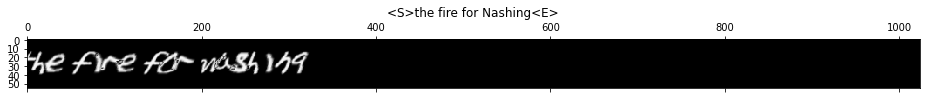

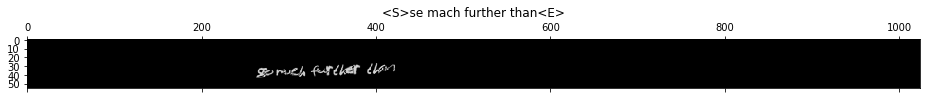

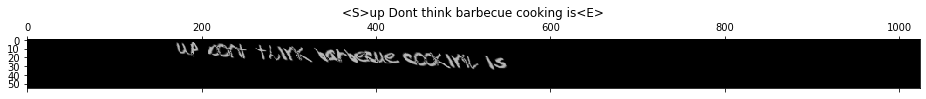

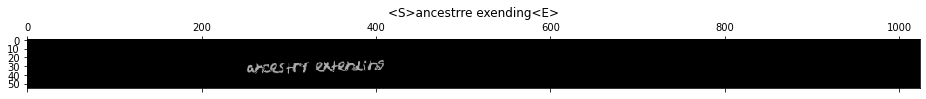

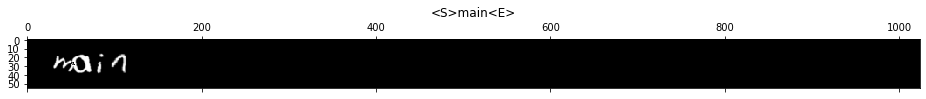

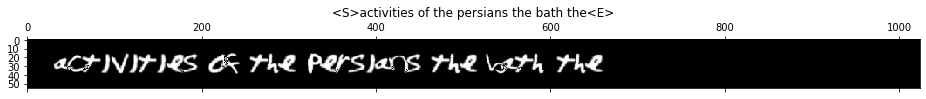

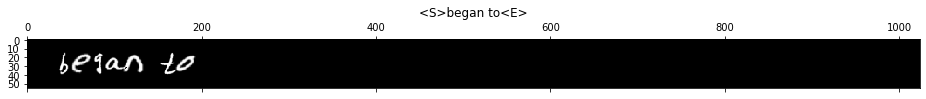

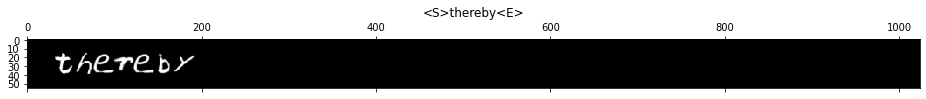

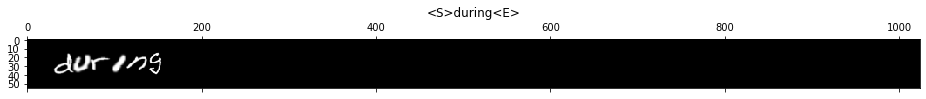

In [7]:
import argparse
from text_recognizer.lit_models import TransformerLitModel
from text_recognizer.models import LineCNNTransformer

model = LineCNNTransformer(
    data_config=dataset.config(),
    args=argparse.Namespace()
)
lit_model = TransformerLitModel.load_from_checkpoint(
    '../training/logs/default_fsdl-text-recognizer-2021-training/469_3ocpqryn/checkpoints/epoch=125-step=5039.ckpt',
    model=model,
    args=argparse.Namespace()
)

for i in range(5):
    x, y = dataset.data_train[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)
    
for i in range(5):
    x, y = dataset.data_test[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)